In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet18,resnet50
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns
import os
import sys
import json
import pandas as pd
import numpy as np
from datetime import datetime
import time
from matplotlib import pyplot as plt
from lopo_dataset import LopoDataset

In [3]:
torch.cuda.memory_allocated(0)

0

In [4]:
dataset_name = "minds"
seed = int(np.random.rand() * 100000000)

In [5]:
torch.manual_seed(seed)

In [6]:
# df = pd.read_csv("../datasets/lsa64_dataset_openpose.csv")
df = pd.read_csv("../dataset_output/KSL/ksl_openpose.csv")
# df = pd.read_csv("../dataset_output/libras_minds/libras_minds_openpose_80_frames.csv")
# df = pd.read_csv("../dataset_output/libras_ufop/libras_ufop_openpose_60_frames.csv")

In [7]:
df

,Unnamed: 0,category,video_name,frame,hand_0_0_x,hand_0_0_y,hand_0_0_z,hand_0_1_x,hand_0_1_y,hand_0_1_z,...,pose_22_y,pose_22_z,pose_23_x,pose_23_y,pose_23_z,pose_24_x,pose_24_y,pose_24_z,missing_hand,missing_face
0,0,1,01\00_01.MP4,0,0.582001,0.962902,0.546266,0.556157,0.949455,0.509521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False
1,1,1,01\00_01.MP4,1,0.580137,0.966008,0.477088,0.553618,0.948864,0.412830,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False
2,2,1,01\00_01.MP4,2,0.583498,0.959376,0.528047,0.556080,0.946377,0.515564,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False
3,3,1,01\00_01.MP4,3,0.581389,0.965206,0.442375,0.558085,0.947148,0.481095,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False
4,4,1,01\00_01.MP4,4,0.583501,0.963653,0.462050,0.558553,0.948509,0.505293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108368,1744,77,77\19_77.MP4,120,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False
108369,1745,77,77\19_77.MP4,121,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False
108370,1746,77,77\19_77.MP4,122,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False
108371,1747,77,77\19_77.MP4,123,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False


In [8]:
# Minds only
if "person" not in df.columns:
    import re
    df["person"] = df["video_name"].apply(lambda i: int(re.findall(r".*Sinalizador(\d+)-.+.mp4", i)[0]))

In [9]:
# KSL only
if "person" not in df.columns:
    import re
    df["person"] = df["video_name"].apply(lambda i: int(i.split("\\")[1].split("_")[0]))

In [9]:
# df["person"] = df["video_name"].apply(lambda i: i.split("_")[1])

In [10]:
frames = 60
people = df["person"].unique()
validate_people = people[-1:]
test_people = people[-2:-1]
train_people = people[:-2]

In [91]:
frames = 60
people = df["person"].unique()
validate_people = people[-1:]
test_people = people[-4:]
train_people = people[:-4]

In [92]:
train_people

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [93]:
test_people

array([16, 17, 18, 19])

In [94]:
people

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [95]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [96]:
print("Processing train")
train_dataset = LopoDataset(df, frames, transform, transform_distance=False, person_in=train_people, seed=seed)
print("Processing test")
test_dataset = LopoDataset(df, frames, transform, transform_distance=False, augment=False, person_in=test_people, seed=seed, print_timing=True)
# print("Processing validate")
# validate_dataset = LopoDataset(df, frames, transform, transform_distance=False, augment=False, person_in=validate_people, seed=seed)
print("Data loaded")

Processing train
Processing test
Data loaded


In [45]:
# Load dataset
# train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
# test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
# validate_dataset = datasets.ImageFolder(root=validate_dir, transform=transform)

In [46]:
# # Split dataset into train and test
# train_size = int(0.8 * len(dataset))
# test_size = len(dataset) - train_size
# train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [97]:
# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
# validate_loader = DataLoader(validate_dataset, batch_size=64, shuffle=False)

In [108]:
# Load pre-trained ResNet18 model
resnet = resnet18(pretrained=True)

In [43]:
# Load pre-trained ResNet18 model
# resnet = resnet50(pretrained=True)

/home/dudu/anaconda3/envs/tf/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dudu/anaconda3/envs/tf/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/dudu/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:01<00:00, 89.4MB/s]


In [99]:
num_ftrs = resnet.fc.in_features

In [70]:
num_features = 20

In [109]:
num_features = len(df["category"].unique())
num_features

67

In [101]:
# Modify the fully connected layer to match the number of classes
# resnet.fc = nn.Linear(num_ftrs, num_features)

In [110]:
# Add an extra dense layer
resnet.fc = nn.Sequential(
    nn.BatchNorm1d(num_ftrs),
    nn.Linear(num_ftrs, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, num_features)
)

In [111]:
total_params = 0
for name, parameter in resnet.named_parameters():
    if not parameter.requires_grad:
        continue
    param = parameter.numel()
    total_params += param
    print(f"{name} has {param} parameters")
print(f"Total number of parameters: {total_params}")

conv1.weight has 9408 parameters
bn1.weight has 64 parameters
bn1.bias has 64 parameters
layer1.0.conv1.weight has 36864 parameters
layer1.0.bn1.weight has 64 parameters
layer1.0.bn1.bias has 64 parameters
layer1.0.conv2.weight has 36864 parameters
layer1.0.bn2.weight has 64 parameters
layer1.0.bn2.bias has 64 parameters
layer1.1.conv1.weight has 36864 parameters
layer1.1.bn1.weight has 64 parameters
layer1.1.bn1.bias has 64 parameters
layer1.1.conv2.weight has 36864 parameters
layer1.1.bn2.weight has 64 parameters
layer1.1.bn2.bias has 64 parameters
layer2.0.conv1.weight has 73728 parameters
layer2.0.bn1.weight has 128 parameters
layer2.0.bn1.bias has 128 parameters
layer2.0.conv2.weight has 147456 parameters
layer2.0.bn2.weight has 128 parameters
layer2.0.bn2.bias has 128 parameters
layer2.0.downsample.0.weight has 8192 parameters
layer2.0.downsample.1.weight has 128 parameters
layer2.0.downsample.1.bias has 128 parameters
layer2.1.conv1.weight has 147456 parameters
layer2.1.bn1.weig

In [112]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(resnet.parameters(), lr=10e-5)
optimizer_parameters = {
    "lr": 1e-4,
    "weight_decay": 1e-4
}
optimizer = optim.Adam(resnet.parameters(), **optimizer_parameters)

In [113]:
# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [106]:
len(test_loader.dataset)

258

In [72]:
resnet.load_state_dict(torch.load("results/15/minds/models/2024-04-13_15:13:24.225795.pth"))

<All keys matched successfully>

In [75]:
resnet.fc[-1] = nn.Linear(128, num_features)

In [76]:
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [114]:
epochs = 50
history = {"loss": [], "accuracy": [], "val_accuracy": []}
best_val_loss = float('inf')
best_val_accuracy = 0
best_model_weights = resnet.state_dict()
patience = 5
counter = 0
torch.cuda.reset_peak_memory_stats(device)
torch.cuda.synchronize()
start_time = time.time()

for epoch in range(epochs):
    resnet.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        if len(inputs) == 1:
            continue
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
        
    epoch_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct_train / total_train
    history["loss"].append(float(epoch_loss))
    history["accuracy"].append(float(train_accuracy))
    
#     resnet.eval()
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for inputs, labels in validate_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = resnet(inputs)
#             _, predicted = torch.max(outputs, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#         val_accuracy = correct / total
#         val_loss = criterion(outputs, labels)
#         history["loss"].append(float(epoch_loss))
#         history["accuracy"].append(float(train_accuracy))
#         history["val_accuracy"].append(float(val_accuracy))
        
#     if val_accuracy > best_val_accuracy:
#         best_val_accuracy = val_accuracy
#         best_model_weights = resnet.state_dict()
        
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         counter = 0
#     else:
#         counter += 1
#         if counter >= patience:
#             print("Early stopping triggered. No improvement in validation loss.")
#             break

    
#     print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(str(datetime.now()))
    
end_time = time.time()
torch.cuda.synchronize()
peak_memory_usage = torch.cuda.max_memory_allocated(device) / (1024 ** 2)  # Convert to GB
print(f'Peak VRAM usage during training: {peak_memory_usage:.3f} MB')
print(f"Total duration: {(end_time - start_time)}s")

Epoch 1/50, Train Loss: 4.2455, Train Accuracy: 0.0113
2024-05-02 21:18:17.740805
Epoch 2/50, Train Loss: 4.0927, Train Accuracy: 0.0402
2024-05-02 21:18:19.536673
Epoch 3/50, Train Loss: 3.9917, Train Accuracy: 0.0639
2024-05-02 21:18:21.344408
Epoch 4/50, Train Loss: 3.8774, Train Accuracy: 0.0834
2024-05-02 21:18:23.160802
Epoch 5/50, Train Loss: 3.7159, Train Accuracy: 0.1483
2024-05-02 21:18:24.963709
Epoch 6/50, Train Loss: 3.5765, Train Accuracy: 0.1833
2024-05-02 21:18:26.779955
Epoch 7/50, Train Loss: 3.4291, Train Accuracy: 0.2142
2024-05-02 21:18:28.579779
Epoch 8/50, Train Loss: 3.2674, Train Accuracy: 0.2636
2024-05-02 21:18:30.377830
Epoch 9/50, Train Loss: 3.1063, Train Accuracy: 0.3090
2024-05-02 21:18:32.175588
Epoch 10/50, Train Loss: 2.9733, Train Accuracy: 0.3306
2024-05-02 21:18:33.976191
Epoch 11/50, Train Loss: 2.8376, Train Accuracy: 0.3697
2024-05-02 21:18:35.781944
Epoch 12/50, Train Loss: 2.6504, Train Accuracy: 0.4264
2024-05-02 21:18:37.559351
Epoch 13/50, 

In [115]:
(end_time - start_time) * 1000

90759.50050354004

In [36]:
# Load the best model weights
resnet.load_state_dict(best_model_weights)
print("Best val accuracy:", best_val_accuracy)

Best val accuracy: 0.9


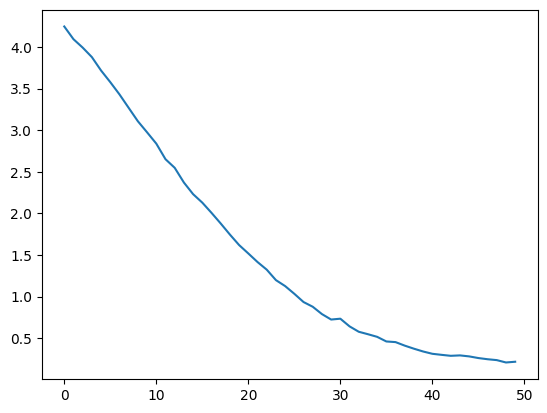

In [116]:
plt.plot(history["loss"])

In [117]:
resnet.eval()
correct = 0
total = 0
class_correct = list(0. for _ in range(num_features))
class_total = list(0. for _ in range(num_features))

In [118]:
pre_alocated = torch.cuda.memory_allocated(0)

In [119]:
allocations = []
with torch.no_grad():
    for inputs, labels in test_loader:
        start_allocated = torch.cuda.memory_allocated(0)
        inputs, labels = inputs.to(device), labels.to(device)
        end_allocated = torch.cuda.memory_allocated(0)
        allocations.append((len(inputs), end_allocated - start_allocated))

landmarks_to_image duration: 7.2479248046875e-05
landmarks_to_image duration: 2.9802322387695312e-05
landmarks_to_image duration: 1.8358230590820312e-05
landmarks_to_image duration: 2.6941299438476562e-05
landmarks_to_image duration: 3.6716461181640625e-05
landmarks_to_image duration: 2.6464462280273438e-05
landmarks_to_image duration: 2.1457672119140625e-05
landmarks_to_image duration: 2.7179718017578125e-05
landmarks_to_image duration: 4.673004150390625e-05
landmarks_to_image duration: 2.86102294921875e-05
landmarks_to_image duration: 1.5974044799804688e-05
landmarks_to_image duration: 2.4318695068359375e-05
landmarks_to_image duration: 3.24249267578125e-05
landmarks_to_image duration: 2.574920654296875e-05
landmarks_to_image duration: 4.100799560546875e-05
landmarks_to_image duration: 3.24249267578125e-05
landmarks_to_image duration: 4.2438507080078125e-05
landmarks_to_image duration: 2.4080276489257812e-05
landmarks_to_image duration: 1.71661376953125e-05
landmarks_to_image duratio

landmarks_to_image duration: 2.8371810913085938e-05
landmarks_to_image duration: 4.38690185546875e-05


In [120]:
allocations

[(64, 38535680), (64, 38535680), (64, 38535680), (64, 38535680), (2, 1311232)]

In [121]:
for a in allocations:
    print(f"Items: {a[0]}. VRAM: {a[1]/1e6}mb")

Items: 64. VRAM: 38.53568mb
Items: 64. VRAM: 38.53568mb
Items: 64. VRAM: 38.53568mb
Items: 64. VRAM: 38.53568mb
Items: 2. VRAM: 1.311232mb


In [122]:
print(38/64)
print(21/36)

0.59375
0.5833333333333334


In [123]:
torch.cuda.reset_peak_memory_stats(device)
torch.cuda.synchronize()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
torch.cuda.synchronize()
peak_memory_usage = torch.cuda.max_memory_allocated(device) / (1024 ** 2)  # Convert to GB
print(f'Peak VRAM usage during training: {peak_memory_usage:.3f} MB')

landmarks_to_image duration: 6.103515625e-05
landmarks_to_image duration: 7.891654968261719e-05
landmarks_to_image duration: 3.218650817871094e-05
landmarks_to_image duration: 2.2172927856445312e-05
landmarks_to_image duration: 2.09808349609375e-05
landmarks_to_image duration: 1.4781951904296875e-05
landmarks_to_image duration: 1.1444091796875e-05
landmarks_to_image duration: 1.33514404296875e-05
landmarks_to_image duration: 2.3365020751953125e-05
landmarks_to_image duration: 1.5974044799804688e-05
landmarks_to_image duration: 1.0251998901367188e-05
landmarks_to_image duration: 1.430511474609375e-05
landmarks_to_image duration: 1.9788742065429688e-05
landmarks_to_image duration: 1.52587890625e-05
landmarks_to_image duration: 1.1444091796875e-05
landmarks_to_image duration: 1.5974044799804688e-05
landmarks_to_image duration: 2.1457672119140625e-05
landmarks_to_image duration: 2.3603439331054688e-05
landmarks_to_image duration: 9.775161743164062e-06
landmarks_to_image duration: 1.5974044

landmarks_to_image duration: 6.079673767089844e-05
landmarks_to_image duration: 6.985664367675781e-05
Peak VRAM usage during training: 1015.379 MB


In [124]:
# Evaluate on test set
resnet.eval()
correct = 0
total = 0
predicted_labels = []
true_labels = []
start_time = datetime.now()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        
end_time = datetime.now()

accuracy = correct / total
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')

landmarks_to_image duration: 5.1975250244140625e-05
landmarks_to_image duration: 0.00011754035949707031
landmarks_to_image duration: 2.384185791015625e-05
landmarks_to_image duration: 3.790855407714844e-05
landmarks_to_image duration: 3.910064697265625e-05
landmarks_to_image duration: 3.218650817871094e-05
landmarks_to_image duration: 2.002716064453125e-05
landmarks_to_image duration: 2.8371810913085938e-05
landmarks_to_image duration: 4.76837158203125e-05
landmarks_to_image duration: 3.24249267578125e-05
landmarks_to_image duration: 1.8358230590820312e-05
landmarks_to_image duration: 3.62396240234375e-05
landmarks_to_image duration: 3.910064697265625e-05
landmarks_to_image duration: 3.4332275390625e-05
landmarks_to_image duration: 3.147125244140625e-05
landmarks_to_image duration: 2.2649765014648438e-05
landmarks_to_image duration: 2.9087066650390625e-05
landmarks_to_image duration: 1.6689300537109375e-05
landmarks_to_image duration: 1.0967254638671875e-05
landmarks_to_image duration:

/home/dudu/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [125]:
total_duration = (end_time - start_time).total_seconds() * 1000
print("Duration(ms):", total_duration)
print("Duration per video(ms):", total_duration/len(test_loader.dataset) )

Duration(ms): 373.296
Duration per video(ms): 1.4468837209302325


In [126]:
print(f"Accuracy on the test set: {accuracy:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

Accuracy on the test set: 0.5930
Precision: 0.6392, Recall: 0.5933, F1 Score: 0.5786


In [89]:
accuracy = correct / total
print(f"Accuracy on the test set: {accuracy:.4f}")

Accuracy on the test set: 0.4489


In [90]:
categories = [i+1 for i in range(num_features)]

In [57]:
precisions = []
for i in range(num_features):
    precision = class_correct[i] / class_total[i]
    precisions.append(precision)
    if precision < 1:
        print(f"Precision of class {i}: {precision:.4f}")
# plt.bar(categories, precision)

Precision of class 0: 0.6000
Precision of class 1: 0.8000
Precision of class 2: 0.6000
Precision of class 3: 0.6000
Precision of class 4: 0.8000
Precision of class 5: 0.2000
Precision of class 6: 0.8000
Precision of class 8: 0.8000
Precision of class 10: 0.4000
Precision of class 12: 0.5000
Precision of class 14: 0.4000
Precision of class 15: 0.2000
Precision of class 16: 0.8000
Precision of class 18: 0.4000
Precision of class 19: 0.0000
Precision of class 22: 0.2500
Precision of class 24: 0.8000
Precision of class 25: 0.4000
Precision of class 26: 0.2000
Precision of class 27: 0.8000
Precision of class 28: 0.4000
Precision of class 29: 0.6000
Precision of class 30: 0.2000
Precision of class 31: 0.8000
Precision of class 32: 0.4000
Precision of class 33: 0.2500
Precision of class 34: 0.5000
Precision of class 35: 0.4000
Precision of class 36: 0.4000
Precision of class 37: 0.4000
Precision of class 38: 0.2000
Precision of class 39: 0.4000
Precision of class 40: 0.8000
Precision of class

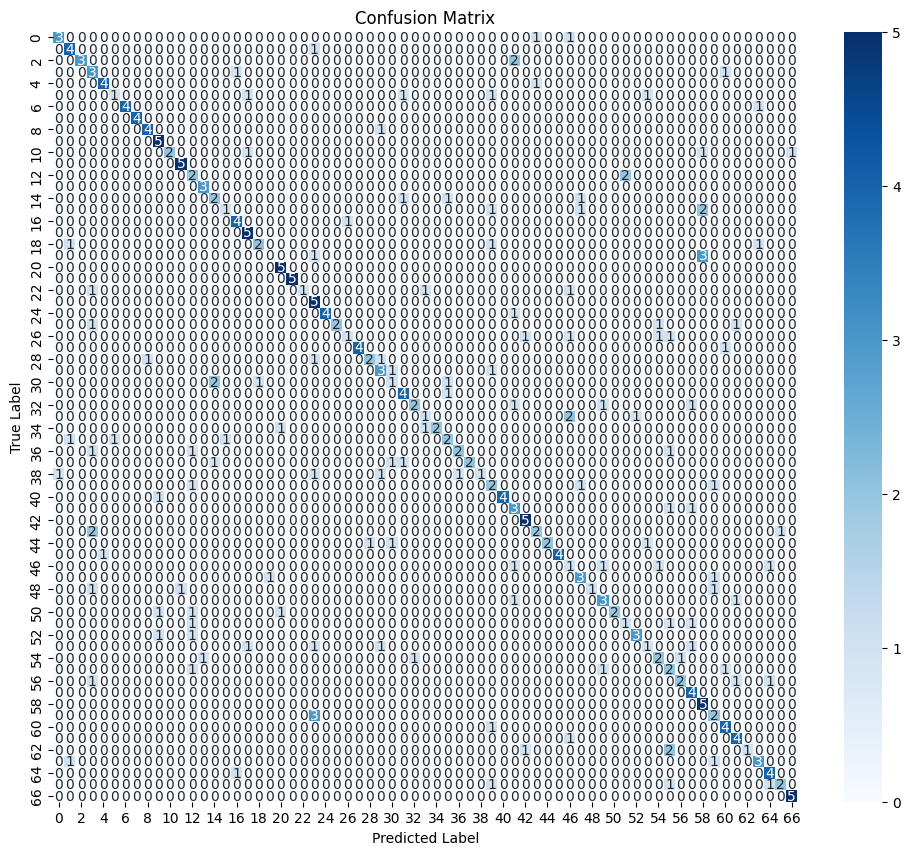

In [58]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [59]:
0.91 - accuracy

0.3310526315789474

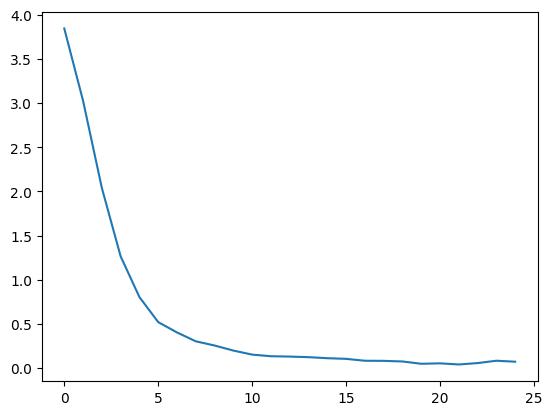

In [63]:
plt.plot(history["loss"])

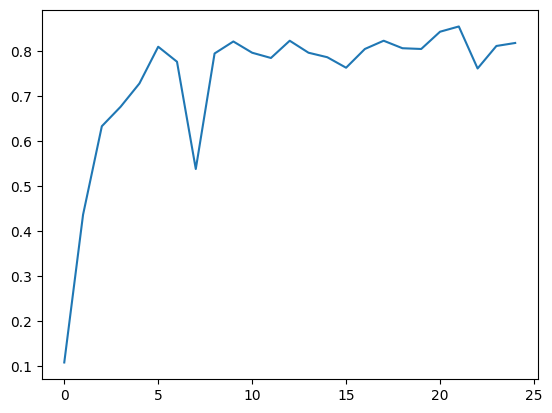

In [64]:
plt.plot(history["val_accuracy"])

In [136]:
result = {
    "dataset_name": dataset_name,
    "frames": frames,
    "seed": seed,
    "epochs": epochs,
    "last_epoch": epoch,
    "test_people": test_people.tolist(),
    "validate_people": validate_people.tolist(),
    "resnet_fc_layer": str(resnet.fc),
    "history": history,
    "true_labels": true_labels,
    "predicted_labels": predicted_labels,
    "test_accuracy": accuracy,
    "test_precision": precision,
    "test_recall": float(recall),
    "test_f1_score": float(f1),
}
result

{'dataset_name': 'minds',
 'frames': 80,
 'seed': 4321947,
 'epochs': 25,
 'last_epoch': 24,
 'test_people': [11],
 'validate_people': [12],
 'resnet_fc_layer': 'Sequential(\n  (0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n  (1): Linear(in_features=512, out_features=128, bias=True)\n  (2): ReLU()\n  (3): Dropout(p=0.5, inplace=False)\n  (4): Linear(in_features=128, out_features=20, bias=True)\n)',
 'history': {'loss': [2.873230065084947,
   2.4439844597356553,
   2.006009357209494,
   1.57887721584336,
   1.1804543098975322,
   0.8805239845168367,
   0.660664744939585,
   0.49992811007887933,
   0.3859418735748044,
   0.3065069536202138,
   0.22762283088643268,
   0.18747660629684593,
   0.15256743148622534,
   0.13782548378678602,
   0.1257682118977037,
   0.11136088605837932,
   0.08912399425978203,
   0.09196242581205229,
   0.08347909440265071,
   0.07801123394286708,
   0.06173050956555597,
   0.055808823719029635,
   0.056105447213684594,


In [137]:
validate_people.item()

12

In [138]:
for k, v in result.items():
    print(k, type(v))

dataset_name <class 'str'>
frames <class 'int'>
seed <class 'int'>
epochs <class 'int'>
last_epoch <class 'int'>
test_people <class 'list'>
validate_people <class 'list'>
resnet_fc_layer <class 'str'>
history <class 'dict'>
true_labels <class 'list'>
predicted_labels <class 'list'>
test_accuracy <class 'float'>
test_precision <class 'float'>
test_recall <class 'float'>
test_f1_score <class 'float'>


In [145]:
file_name = str(datetime.now()).replace(":", "_").replace(" ", "_")
file_path = os.path.join("results", dataset_name, file_name + ".json")
model_path = os.path.join("results", dataset_name, "models", file_name + ".pth")
with open(file_path, "w") as f:
    json.dump(result, f, default=int)

torch.save(resnet.state_dict(), model_path)

In [143]:
file_name

'2024-03-31_14_42_11.375710'